# FraudLens Model Training
This notebook loads Facebook-scraped datasets, preprocesses posts and reviews, and trains a hybrid model using TF-IDF + Isolation Forest.

In [58]:
!pip install seaborn
!pip install sentence-transformers
!pip install altair

### Load JSON files into a combined

In [59]:

import os
import json
import re
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
import joblib

# Define dataset directory
data_dir = Path("..") / "data"
combined_df = []
reviews_corpus = []
print("All JSON files in data/:", list(data_dir.glob("*.json")))
print("path is:", data_dir)

matching_files = list(data_dir.glob("final_scraped_dataset_*.json"))
print("Matching files:", matching_files)

for file in matching_files:
    try:
        with open(file, "r", encoding="utf-8") as f:
            data = json.load(f)

            # Safely load posts
            posts = data.get("Posts", [])
            if isinstance(posts, list) and all(isinstance(p, dict) for p in posts):
                posts_df = pd.DataFrame(posts)
                posts_df["About"] = [data.get("About", "")] * len(posts_df)
                posts_df["Recommendation"] = [data.get("Recommendation", "")] * len(posts_df)
                combined_df.append(posts_df)
            else:
                print(f"⚠️ Skipping file (invalid Posts list): {file.name}")

            # Collect all review strings
            for r in data.get("Reviews", []):
                if isinstance(r, dict) and r.get("Review"):
                    reviews_corpus.append(r["Review"])

    except Exception as e:
        print(f"❌ Error reading {file.name}: {e}")





df = pd.concat(combined_df, ignore_index=True) if combined_df else pd.DataFrame()
print("Total posts loaded:", len(df))


All JSON files in data/: [WindowsPath('../data/final_scraped_dataset_100051030403914.json'), WindowsPath('../data/final_scraped_dataset_100063353553077.json'), WindowsPath('../data/final_scraped_dataset_100063672633782.json'), WindowsPath('../data/final_scraped_dataset_100063685825408.json'), WindowsPath('../data/final_scraped_dataset_100063967546145.json'), WindowsPath('../data/final_scraped_dataset_100064091642893.json'), WindowsPath('../data/final_scraped_dataset_100065151415346.json'), WindowsPath('../data/final_scraped_dataset_100066265554659.json'), WindowsPath('../data/final_scraped_dataset_100067310875029.json'), WindowsPath('../data/final_scraped_dataset_100075661729175.json'), WindowsPath('../data/final_scraped_dataset_100075925544978.json'), WindowsPath('../data/final_scraped_dataset_100076582564580.json'), WindowsPath('../data/final_scraped_dataset_100078863471466.json'), WindowsPath('../data/final_scraped_dataset_100079608703063.json'), WindowsPath('../data/final_scraped_d

### Preprocess posts (clean text, features)

In [60]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r'… see more', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text.strip()

def preprocess(df):
    df['Cleaned Content'] = df['Post Content'].fillna("").apply(clean_text)
    df['Post Length'] = df['Cleaned Content'].apply(len)
    df['Num Comments'] = df['Comments'].apply(len)
    df['Total Reactions'] = df['Reactions'].apply(lambda x: sum(x.values()) if isinstance(x, dict) else 0)
    df['Angry Ratio'] = df['Reactions'].apply(lambda x: x.get('Angry', 0) / sum(x.values()) if sum(x.values()) > 0 else 0)
    df['Sad Ratio'] = df['Reactions'].apply(lambda x: x.get('Sad', 0) / sum(x.values()) if sum(x.values()) > 0 else 0)
    df['Haha Ratio'] = df['Reactions'].apply(lambda x: x.get('Haha', 0) / sum(x.values()) if sum(x.values()) > 0 else 0)
    df['Love Ratio'] = df['Reactions'].apply(lambda x: x.get('Love', 0) / sum(x.values()) if sum(x.values()) > 0 else 0)
    return df

if not df.empty:
    df = preprocess(df)
    print("Preprocessing complete.")
    display(display(df))
else:
    print("⚠️ No data to preprocess.")


Preprocessing complete.


,Post Content,Comments,Reactions,Timestamp,About,Recommendation,Cleaned Content,Post Length,Num Comments,Total Reactions,Angry Ratio,Sad Ratio,Haha Ratio,Love Ratio
0,New arrival alert! This one won’t last long — ...,[],{},2025-04-29T20:30:42.571620,"{'Address': 'Colombo, Sri Lanka', 'Contact': '...",not available,new arrival alert this one wont last long com...,152,0,0,0.0,0.0,0.0,0.0
1,New arrival alert! This one won’t last long — ...,[],{},2025-04-29T20:30:42.587868,"{'Address': 'Colombo, Sri Lanka', 'Contact': '...",not available,new arrival alert this one wont last long com...,152,0,0,0.0,0.0,0.0,0.0
2,New arrival alert! This one won’t last long — ...,[],{},2025-04-29T20:30:42.597541,"{'Address': 'Colombo, Sri Lanka', 'Contact': '...",not available,new arrival alert this one wont last long com...,152,0,0,0.0,0.0,0.0,0.0
3,New arrival alert! This one won’t last long — ...,[],{'Like': 3},2025-04-29T20:30:42.618098,"{'Address': 'Colombo, Sri Lanka', 'Contact': '...",not available,new arrival alert this one wont last long com...,152,0,3,0.0,0.0,0.0,0.0
4,""" FOR SALE: Honda ATIV! Stylish, fuel-efficie...",[],{},2025-04-29T20:30:42.647305,"{'Address': 'Colombo, Sri Lanka', 'Contact': '...",not available,for sale honda ativ stylish fuelefficient and...,148,0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047,Hamilton Khaki Field Model : H70455533… See more,[Price ?],{},2025-04-28T21:47:32.983204,"{'Address': 'Colombo, Sri Lanka'}",100% recommend (27 reviews)﻿,hamilton khaki field model h70455533,37,1,0,0.0,0.0,0.0,0.0
1048,TAG HEUER CARRERACHRONOGRAPH… See more,[],{'Like': 2},2025-04-28T21:47:33.004870,"{'Address': 'Colombo, Sri Lanka'}",100% recommend (27 reviews)﻿,tag heuer carrerachronograph,28,0,2,0.0,0.0,0.0,0.0
1049,TAG HEUER CARRERApre owned … See more,[],{'Like': 2},2025-04-28T21:47:33.039407,"{'Address': 'Colombo, Sri Lanka'}",100% recommend (27 reviews)﻿,tag heuer carrerapre owned,26,0,2,0.0,0.0,0.0,0.0
1050,No Text,[],{},2025-04-28T21:47:33.045573,"{'Address': 'Colombo, Sri Lanka'}",100% recommend (27 reviews)﻿,no text,7,0,0,0.0,0.0,0.0,0.0


None

### Generate Sentence-BERT embeddings (Fine-tuned) + SBERT Similarity + plot

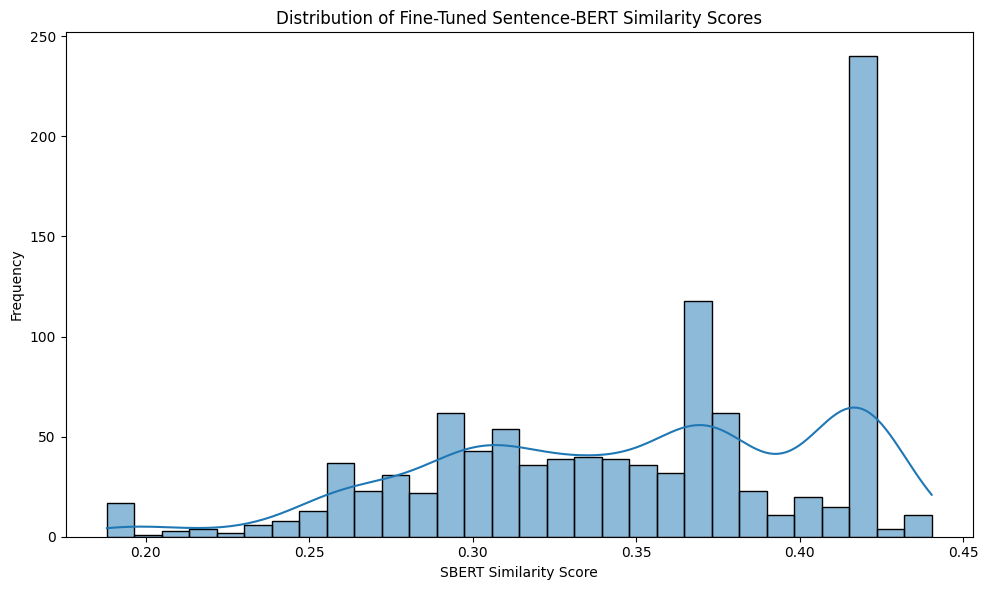

In [61]:
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns

# Load fine-tuned Sentence-BERT model
sbert_model = SentenceTransformer("./fine_tuned_sbert_fraudlens/")

# Encode post content with fine-tuned Sentence-BERT
sbert_embeddings = sbert_model.encode(df['Cleaned Content'].tolist(), convert_to_tensor=True)

# Compute pairwise cosine similarities
cosine_scores = util.pytorch_cos_sim(sbert_embeddings, sbert_embeddings)

# Average similarity for each post
df['SBERT_Similarity'] = cosine_scores.mean(dim=1).cpu().numpy()

# Visualize distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['SBERT_Similarity'], bins=30, kde=True)
plt.title("Distribution of Fine-Tuned Sentence-BERT Similarity Scores")
plt.xlabel("SBERT Similarity Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### Fine-tune SBERT model

In [62]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

# Step 1: Load Pretrained Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Step 2: Prepare Training Examples
examples = [InputExample(texts=[text, text], label=1.0) for text in df['Cleaned Content']]

# Step 3: DataLoader
train_dataloader = DataLoader(examples, shuffle=True, batch_size=16)

# Step 4: Define Loss
train_loss = losses.CosineSimilarityLoss(model)

# Step 5: Fine-Tune
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=1,
    warmup_steps=10,
    output_path="./fine_tuned_sbert_fraudlens"
)

print("✅ Fine-tuning complete. Model saved at './fine_tuned_sbert_fraudlens'.")

Epoch: 100%|██████████| 1/1 [05:29<00:00, 329.01s/it]


✅ Fine-tuning complete. Model saved at './fine_tuned_sbert_fraudlens'.


### Use fine-tuned SBERT for embeddings + Logistic Regression classifier to predict SBERT_Prob

In [63]:
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Load fine-tuned Sentence-BERT model
sbert_model = SentenceTransformer("./fine_tuned_sbert_fraudlens/")

# Generate embeddings for post content
sbert_embeddings = sbert_model.encode(df['Cleaned Content'].tolist(), show_progress_bar=True)

# Convert to DataFrame
sbert_df = pd.DataFrame(sbert_embeddings, columns=[f'sbert_{i}' for i in range(sbert_embeddings.shape[1])])

# Merge embeddings into original dataframe
df = pd.concat([df.reset_index(drop=True), sbert_df.reset_index(drop=True)], axis=1)

print("✅ SBERT embeddings generated.")


Batches: 100%|██████████| 33/33 [00:19<00:00,  1.72it/s]

✅ SBERT embeddings generated.


### Train TF-IDF classifier + Anomaly Detection + Compute FraudLens_Score

In [64]:
# Train TF-IDF + Logistic Regression
tfidf = TfidfVectorizer(max_features=100)
X_reviews = tfidf.fit_transform(reviews_corpus + df['Cleaned Content'].tolist())
dummy_labels = [0] * len(reviews_corpus) + [1] * len(df)
clf_text = LogisticRegression().fit(X_reviews, dummy_labels)

X_text = tfidf.transform(df['Cleaned Content'])
df['Text_Prob'] = clf_text.predict_proba(X_text)[:, 1]

# Anomaly Detection
features = ['Post Length', 'Num Comments', 'Total Reactions', 'Angry Ratio', 'Sad Ratio', 'Haha Ratio', 'Love Ratio']
X_behavior = df[features].fillna(0)
anomaly_model = IsolationForest(contamination=0.15, random_state=42)
df['Anomaly_Score'] = -anomaly_model.fit(X_behavior).decision_function(X_behavior)

#  Train a classifier to predict SBERT_Prob
X_train, X_test, y_train, y_test = train_test_split(sbert_df, np.random.randint(0,2,len(df)), test_size=0.2, random_state=42)

sbert_clf = LogisticRegression(max_iter=1000)
sbert_clf.fit(X_train, y_train)

# Predict probabilities
df['SBERT_Prob'] = sbert_clf.predict_proba(sbert_df)[:, 1]

# Final Score + Export
# Derive trust score based on positive engagement
df['Trust_Score'] = (
    0.6 * df['Love Ratio'] + 
    0.2 * df['Haha Ratio'] + 
    0.1 * (df['Post Length'] / df['Post Length'].max()) + 
    0.1 * (1 - df['Angry Ratio'])
)

# Clip trust score between 0.4 and 1.0
df['Trust_Score'] = df['Trust_Score'].clip(lower=0.4, upper=1.0)
df['FraudLens_Score'] = 0.4 * df['SBERT_Prob'] + 0.4 * df['Anomaly_Score'] + 0.2 * (1 - df['Trust_Score'])
df['Fraud_Prediction'] = df['FraudLens_Score'].apply(lambda x: 1 if x > 0.3 else 0)

# Export
df.to_csv("fraudlens_training_output.csv", index=False)
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(sbert_clf, "logistic_model_sbert.pkl")
joblib.dump(anomaly_model, "isolation_model.pkl")
print("✅ Models and results saved.")

print("✅ Training complete. Showing top suspicious posts:")
df[df['Fraud_Prediction'] == 1][['Post Content', 'FraudLens_Score', 'Text_Prob', 'Anomaly_Score']]


C:\Users\hgamage\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


✅ Models and results saved.
✅ Training complete. Showing top suspicious posts:


,Post Content,FraudLens_Score,Text_Prob,Anomaly_Score
84,No Text,0.301252,0.949795,-0.091542
132,ඔයා කැමතිම සපත්තුව අපෙන් #MadeForYou #ForHer #...,0.305156,0.869702,-0.156060
133,ඔයා කැමතිම සපත්තුව අපෙන් #MadeForYou #ForHer #...,0.324850,0.869702,-0.106824
198,Dancing DuckBoard pull Tab Book,0.303978,0.869702,-0.003390
201,Hop HopeSlide and seek… See more,0.305207,0.800653,-0.002837
...,...,...,...,...
1018,One Day Class for Basic Cookie Decorating.එක් ...,0.306744,0.927783,-0.125796
1024,One Day Dessert Cakes Workshop.එක් දින ඩිසර්ට්...,0.314576,0.955970,-0.055735
1032,වොයිලා අපේ අතින් නිමවුණු කේක් නිර්මාණ ලස්සනයි...,0.307964,0.869702,-0.064719
1033,වොයිලා අපේ අතින් නිමවුණු කේක් නිර්මාණ ලස්සනයි...,0.313471,0.869702,-0.050952


### 📊 FraudLens Score Distribution

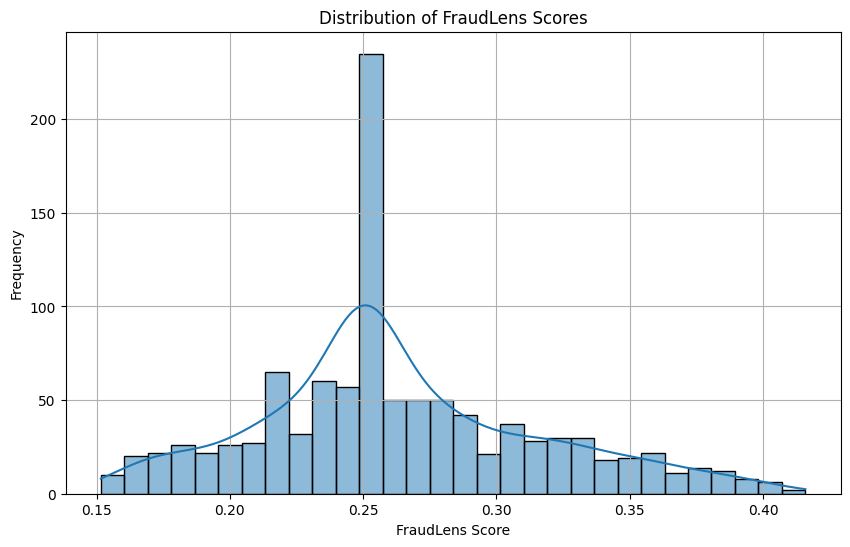

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['FraudLens_Score'], bins=30, kde=True)
plt.title("Distribution of FraudLens Scores")
plt.xlabel("FraudLens Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


###  Blockchain identity simulation future enhancement

In [66]:
import hashlib
import datetime
import uuid

# Simulated blockchain ledger
blockchain_post_ledger = []

class PostBlockchainIdentity:
    def __init__(self, content, timestamp):
        self.content = content
        self.timestamp = timestamp
        self.did = self.generate_did()
        self.reputation = 100  # starts high
        self.flags = []

    def generate_did(self):
        # Use content + timestamp hash as unique identity for the post
        unique_string = f"{self.content.strip()}|{self.timestamp}"
        return hashlib.sha256(unique_string.encode()).hexdigest()

    def flag(self, fraud_score, reason):
        self.reputation -= 15
        flag_event = {
            "did": self.did,
            "timestamp": datetime.datetime.utcnow().isoformat(),
            "reason": reason,
            "fraud_score": fraud_score,
            "reputation": self.reputation
        }
        blockchain_post_ledger.append(flag_event)
        print(f"🔒 Post flagged on blockchain: {reason} (Score: {fraud_score:.2f})")

    def is_flagged(self):
        return self.reputation < 70

    def __repr__(self):
        return f"DID({self.did[:10]}...), reputation={self.reputation}, flags={len(self.flags)}"

# ✅ Simulated example integration

def blockchain_identity_for_df(df):
    post_registry = {}

    for _, row in df.iterrows():
        content = row['Post Content']
        timestamp = row.get('Timestamp') or datetime.datetime.utcnow().isoformat()
        fraud_score = row.get('FraudLens_Score', 0)
        
        post_identity = PostBlockchainIdentity(content, timestamp)
        post_registry[post_identity.did] = post_identity
        
        if fraud_score > 0.4:
            post_identity.flag(fraud_score, "Automated fraud detection")
    
    return post_registry


post_registry = blockchain_identity_for_df(df[df['Fraud_Prediction'] == 1])

🔒 Post flagged on blockchain: Automated fraud detection (Score: 0.40)
🔒 Post flagged on blockchain: Automated fraud detection (Score: 0.40)
🔒 Post flagged on blockchain: Automated fraud detection (Score: 0.41)
🔒 Post flagged on blockchain: Automated fraud detection (Score: 0.41)
🔒 Post flagged on blockchain: Automated fraud detection (Score: 0.42)
🔒 Post flagged on blockchain: Automated fraud detection (Score: 0.40)
🔒 Post flagged on blockchain: Automated fraud detection (Score: 0.41)
🔒 Post flagged on blockchain: Automated fraud detection (Score: 0.41)


### Fraud Prediction Outcome Count

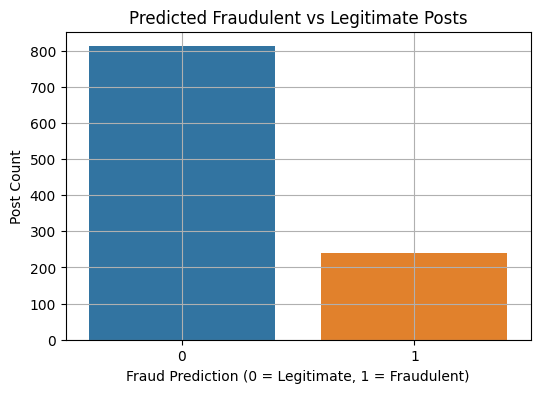

In [67]:
plt.figure(figsize=(6, 4))
sns.countplot(x="Fraud_Prediction", data=df)
plt.title("Predicted Fraudulent vs Legitimate Posts")
plt.xlabel("Fraud Prediction (0 = Legitimate, 1 = Fraudulent)")
plt.ylabel("Post Count")
plt.grid(True)
plt.show()


### Reaction Ratios by Fraud Status

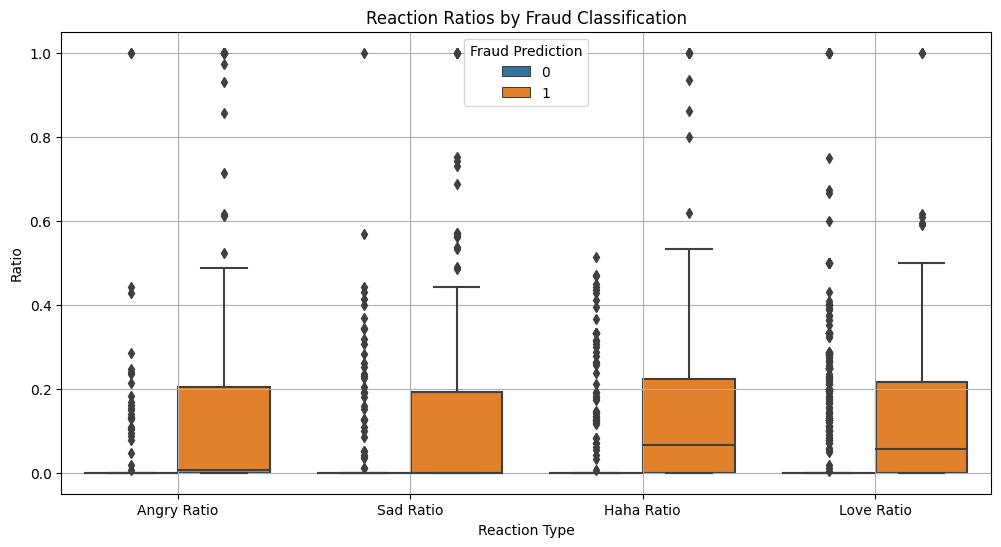

In [68]:
reaction_features = ["Angry Ratio", "Sad Ratio", "Haha Ratio", "Love Ratio"]
melted = df[["Fraud_Prediction"] + reaction_features].melt(id_vars="Fraud_Prediction")

plt.figure(figsize=(12, 6))
sns.boxplot(x="variable", y="value", hue="Fraud_Prediction", data=melted)
plt.title("Reaction Ratios by Fraud Classification")
plt.xlabel("Reaction Type")
plt.ylabel("Ratio")
plt.legend(title="Fraud Prediction")
plt.grid(True)
plt.show()


### Trust Score vs. FraudLens Score Scatter

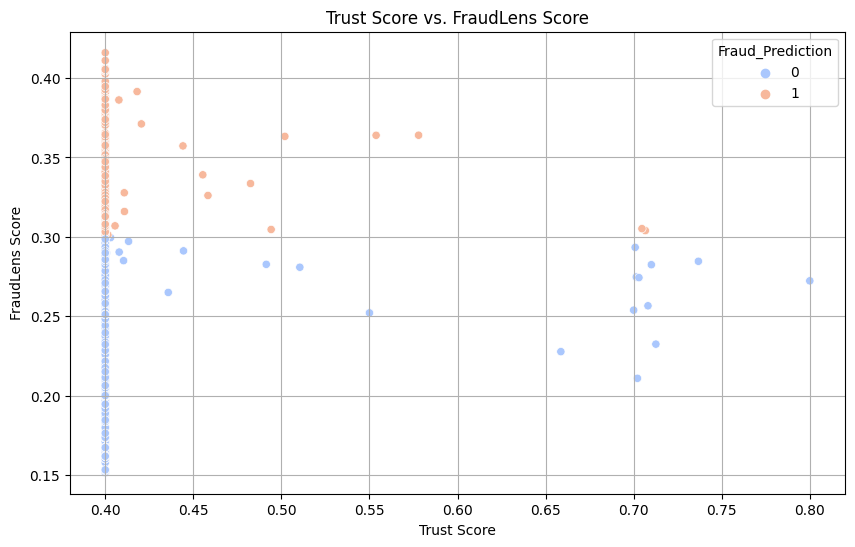

In [69]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Trust_Score", y="FraudLens_Score", hue="Fraud_Prediction", palette="coolwarm")
plt.title("Trust Score vs. FraudLens Score")
plt.xlabel("Trust Score")
plt.ylabel("FraudLens Score")
plt.grid(True)
plt.show()


### Temporal Analysis

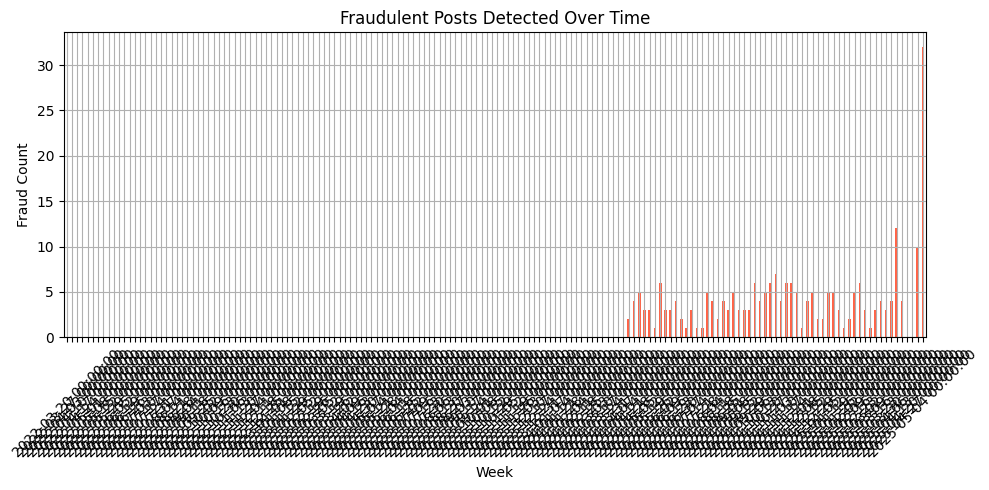

In [70]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors='coerce')
df.set_index("Timestamp", inplace=True)

fraud_over_time = df.resample("W")["Fraud_Prediction"].sum()

plt.figure(figsize=(10, 5))
fraud_over_time.plot(kind="bar", color="tomato")
plt.title("Fraudulent Posts Detected Over Time")
plt.xlabel("Week")
plt.ylabel("Fraud Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


### 4.4.1 Distribution of Post Lengths

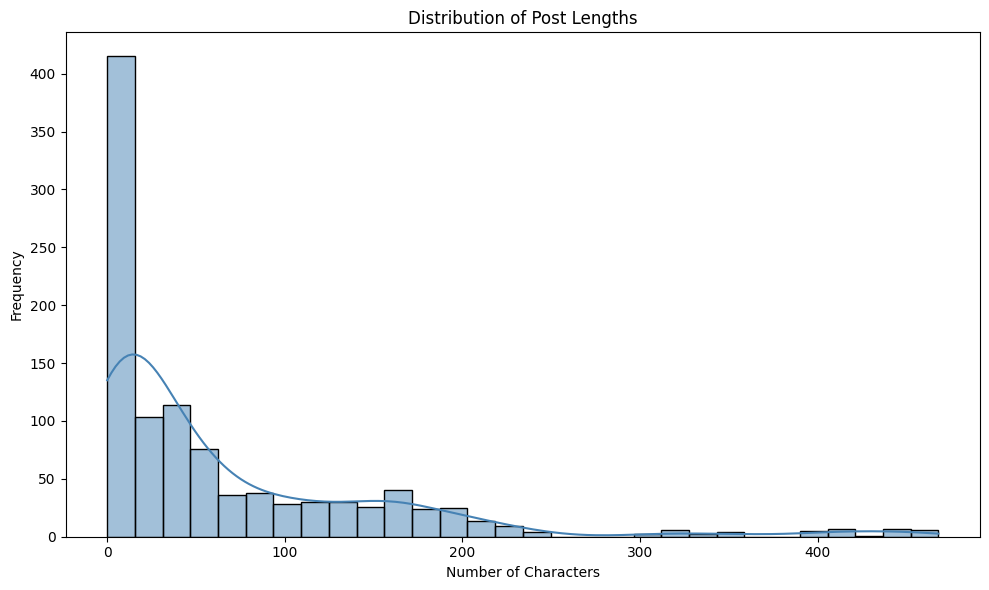

In [71]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Post Length'], bins=30, kde=True, color='steelblue')
plt.title("Distribution of Post Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### 4.4.2 Reaction Ratios by Emotion Type

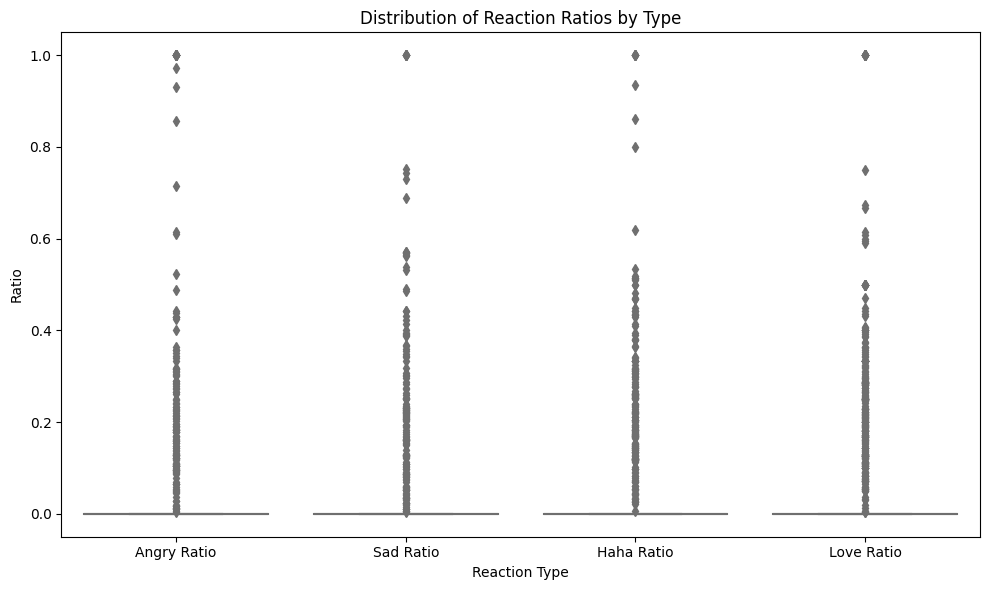

In [72]:
reaction_cols = ['Angry Ratio', 'Sad Ratio', 'Haha Ratio', 'Love Ratio']
df_melted = df[reaction_cols].melt(var_name='Reaction', value_name='Ratio')

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x='Reaction', y='Ratio', palette='pastel')
plt.title("Distribution of Reaction Ratios by Type")
plt.ylabel("Ratio")
plt.xlabel("Reaction Type")
plt.tight_layout()
plt.show()


### 4.4.3 Comments vs. Reactions

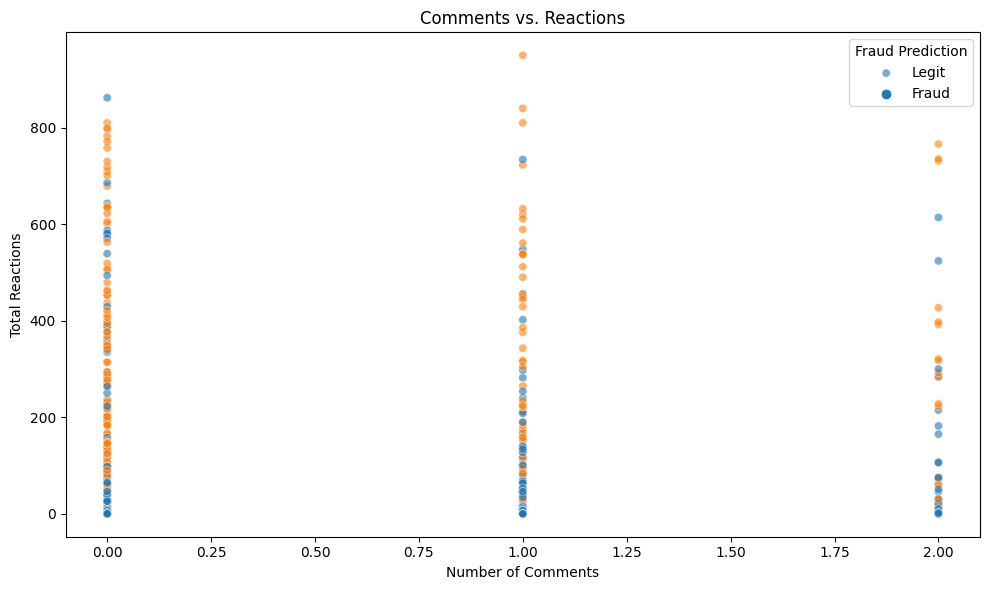

In [73]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Num Comments', y='Total Reactions', hue='Fraud_Prediction', alpha=0.6)
plt.title("Comments vs. Reactions")
plt.xlabel("Number of Comments")
plt.ylabel("Total Reactions")
plt.legend(title="Fraud Prediction", labels=["Legit", "Fraud"])
plt.tight_layout()
plt.show()


### 4.4.4 Behavioral Feature Correlation Matrix

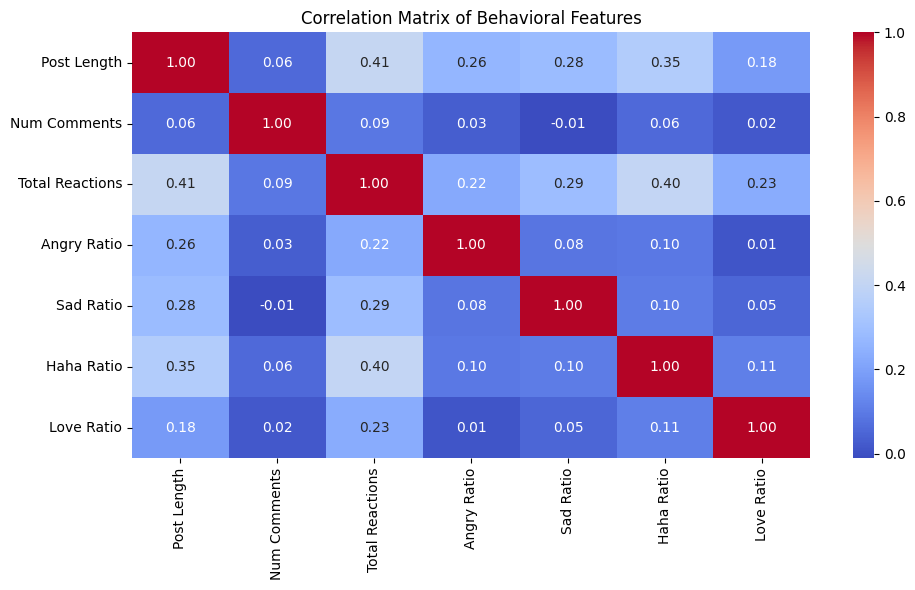

In [74]:
behavior_features = ['Post Length', 'Num Comments', 'Total Reactions', 'Angry Ratio', 'Sad Ratio', 'Haha Ratio', 'Love Ratio']
plt.figure(figsize=(10, 6))
sns.heatmap(df[behavior_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Behavioral Features")
plt.tight_layout()
plt.show()


### 4.5.1 Trust Score Distribution

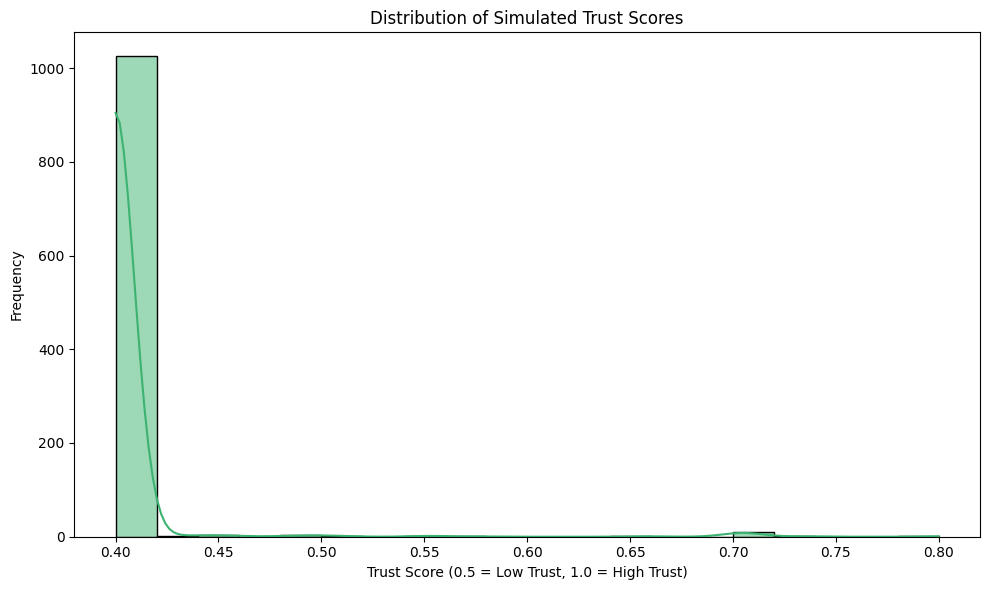

In [75]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Trust_Score'], bins=20, kde=True, color='mediumseagreen')
plt.title("Distribution of Simulated Trust Scores")
plt.xlabel("Trust Score (0.5 = Low Trust, 1.0 = High Trust)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### 4.5.2 Trust Score vs. FraudLens Score

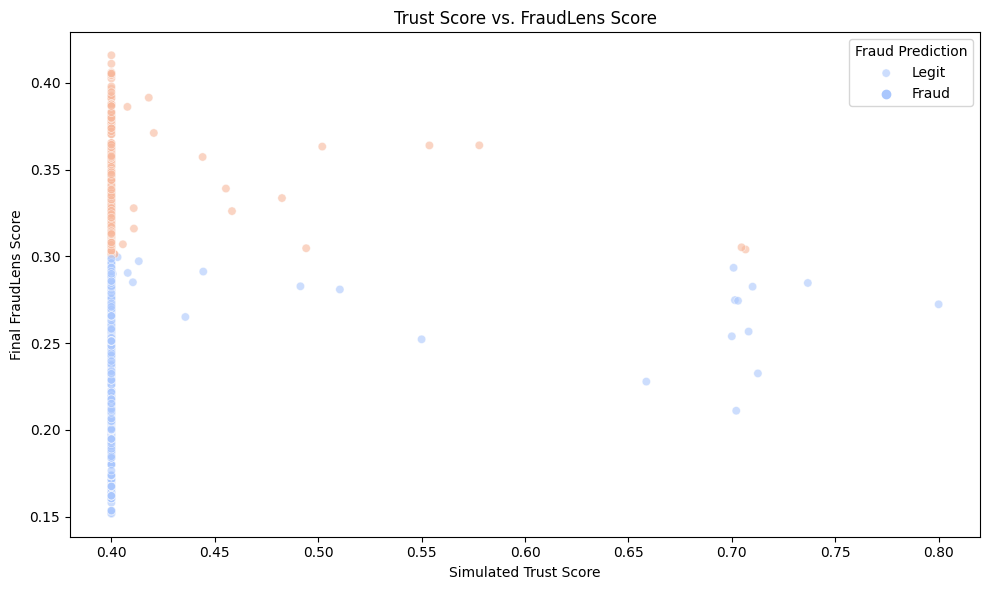

In [76]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Trust_Score', y='FraudLens_Score', hue='Fraud_Prediction', alpha=0.6, palette='coolwarm')
plt.title("Trust Score vs. FraudLens Score")
plt.xlabel("Simulated Trust Score")
plt.ylabel("Final FraudLens Score")
plt.legend(title="Fraud Prediction", labels=["Legit", "Fraud"])
plt.tight_layout()
plt.show()
